<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/temp-anomaly/06.clustering-and-anomaly/06.c.autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard



# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile
import datetime
import shutil
from functools import partial, partialmethod



# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2021-05-03 22:42:50--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py.4’

andrea_models.py.4  100%[===================>]   3.12K  --.-KB/s    in 0s      

2021-05-03 22:42:50 (39.2 MB/s) - ‘andrea_models.py.4’ saved [3190/3190]

--2021-05-03 22:42:50--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.


### Mount google drive

In [9]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/06.clustering-and-anomaly/'

Mounted at /content/gdrive
time: 1.06 s (started: 2021-05-03 22:29:03 +00:00)


### Preprocessing

The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [10]:
np.random.seed(9)
random.seed(9)
tf.random.set_seed(4)

! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

df = pd.read_csv('creditcard.csv')


df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']] 

--2021-05-03 22:29:04--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3033::6815:28dd, ...
Connecting to datahub.io (datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2021-05-03 22:29:06--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3030::ac43:9d26, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv.1’

creditcard.csv.1    100%[===================>] 144.11M   185MB/s    in

To perform model selection, i.e., selecting the best configuration, we will use the ground truth (the normal-anomaly label) and compute the precision-recall curves and the ROC curve.

To avoid **data leakage**, we perform model selection on the training set only

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, 
                                      random_state=9)


time: 133 ms (started: 2021-05-03 22:29:08 +00:00)



We also scale the dataset.

In [12]:
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)

time: 76.1 ms (started: 2021-05-03 22:29:08 +00:00)


In [13]:
n_features = X_tr_scaled.shape[1]
print("The number of features is ", n_features)


The number of features is  29
time: 1.14 ms (started: 2021-05-03 22:29:08 +00:00)


# Functions to build and train a neural net

Let's write the functions to build and train the model, similar to what we did in our [Neural Network's notebook](https://github.com/andreaaraldo/machine-learning-for-networks/tree/master/04.neural_networks).

In [14]:
def make_sequential_model(sample_size, layer_sizes, 
                          hidden_activation_function="relu", 
                          out_activation_function="softmax",
                          loss_fun="categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of 
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying 
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0], 
                  input_dim = sample_size) )
  
  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )
    
  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )
  

  model.compile(loss=loss_fun, 
              optimizer=keras.optimizers.Adam(lr=learning_rate) ,
              metrics=metrics)
  
  return model

time: 16.8 ms (started: 2021-05-03 22:29:08 +00:00)


In [15]:
def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more: 
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))

time: 3.95 ms (started: 2021-05-03 22:29:08 +00:00)


In [16]:
def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000, 
                overwrite=True, validation_split=0.2, patience=20):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training 
            (thanks to the ModelCheckpoint callback (see the implementation 
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.
  
  overwrite: boolean
            If true, the model will be built and trained from scratch, 
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the 
            specified number of epochs
  """
  
  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor 
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the 
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of 
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True) 


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb], 
                      validation_split=validation_split )

  return history

time: 28.6 ms (started: 2021-05-03 22:29:08 +00:00)


# Autoencoder

In [28]:
first_architecture = [10, 5, 10, n_features]
# The encoder is composed of the input layer, with one input per feature
#    and a layer of 10 neurons
# The latent representation is composed of one layer of 5 neurons
# The decoder is composed of a layer of 10 neurons and the output layer
#    

time: 1.57 ms (started: 2021-05-03 22:48:16 +00:00)


Instead of always calling `make_sequential_model(..)` specifying many parameters (that will basically not change all over this notebook, let us use the function `partial` from Python `functools` library

In [33]:
make_autoencoder = partial(make_sequential_model, sample_size=n_features,
                        hidden_activation_function='tanh',
                      out_activation_function='tanh',
                      loss_fun='mean_squared_error',
                      metrics=[])

time: 1.3 ms (started: 2021-05-03 23:24:49 +00:00)


We can now call directly this function `make_autoencoder`

In [30]:
model = make_autoencoder(layer_sizes=first_architecture)

time: 42.4 ms (started: 2021-05-03 22:49:49 +00:00)


We can now train this model

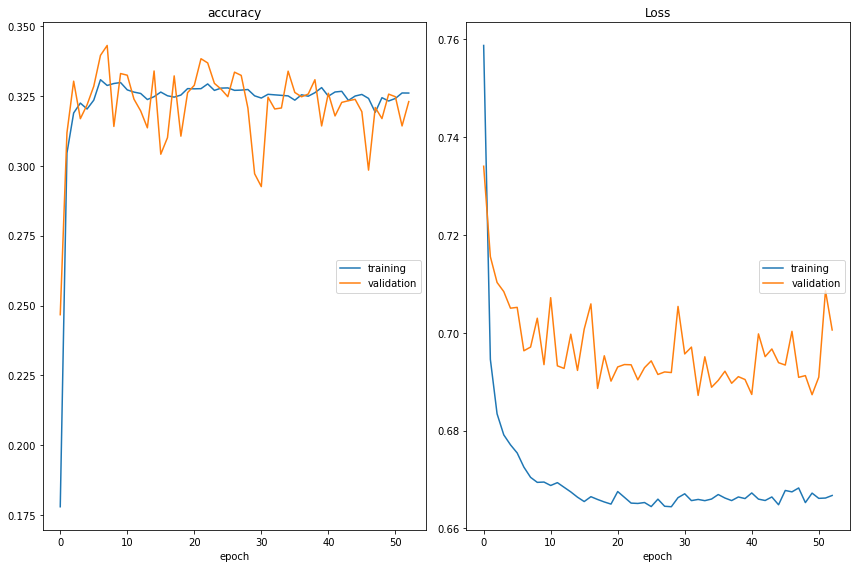

accuracy
	training         	 (min:    0.178, max:    0.331, cur:    0.326)
	validation       	 (min:    0.247, max:    0.343, cur:    0.323)
Loss
	training         	 (min:    0.664, max:    0.759, cur:    0.667)
	validation       	 (min:    0.687, max:    0.734, cur:    0.701)
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
time: 8min 9s (started: 2021-05-03 22:34:39 +00:00)


In [26]:
nn_file = my_path + 'nn1.h5'

history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5, 
                      max_epochs=200)

The loss stops to decrease too soon (only after 50 epochs). It may be due to the learning rate being too high (in the declaration of the function `make_sequential_model`, the default learning rate is 0.02). Let's try with a smaller one

In [31]:
model = make_autoencoder(layer_sizes=first_architecture, learning_rate=0.001)

time: 38.9 ms (started: 2021-05-03 22:54:12 +00:00)


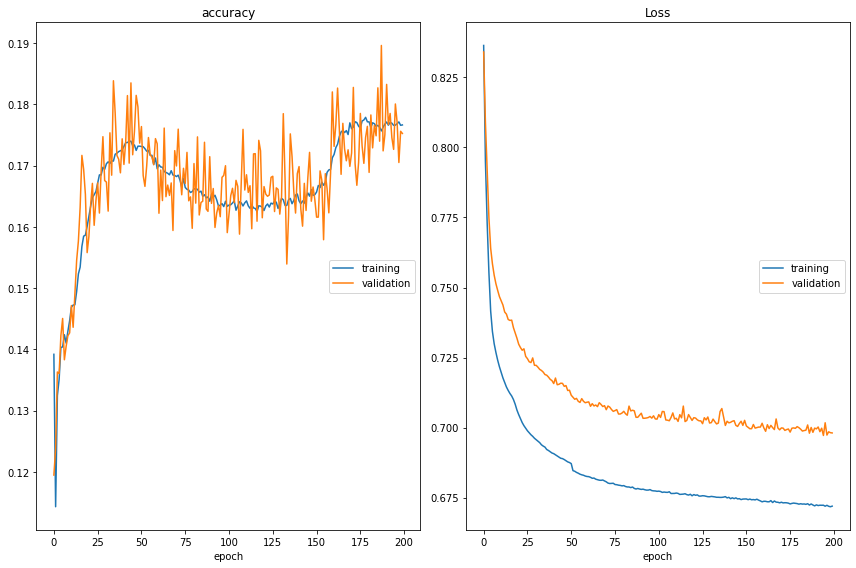

accuracy
	training         	 (min:    0.114, max:    0.178, cur:    0.177)
	validation       	 (min:    0.119, max:    0.190, cur:    0.175)
Loss
	training         	 (min:    0.672, max:    0.836, cur:    0.672)
	validation       	 (min:    0.697, max:    0.834, cur:    0.698)
time: 30min 35s (started: 2021-05-03 22:54:12 +00:00)


In [32]:
nn_file = my_path + 'nn1-lr_0.001.h5'
history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5, 
                      max_epochs=200)

We did not manage to remarkably decrease the loss. 

Let's anyways try to see if we can construct a decent anomaly detector.

# First Anomaly detector

## Model selection: selecting the threshold

The **anomaly score** of each sample is the reconstruction error.

In [34]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

time: 2.8 s (started: 2021-05-03 23:25:10 +00:00)


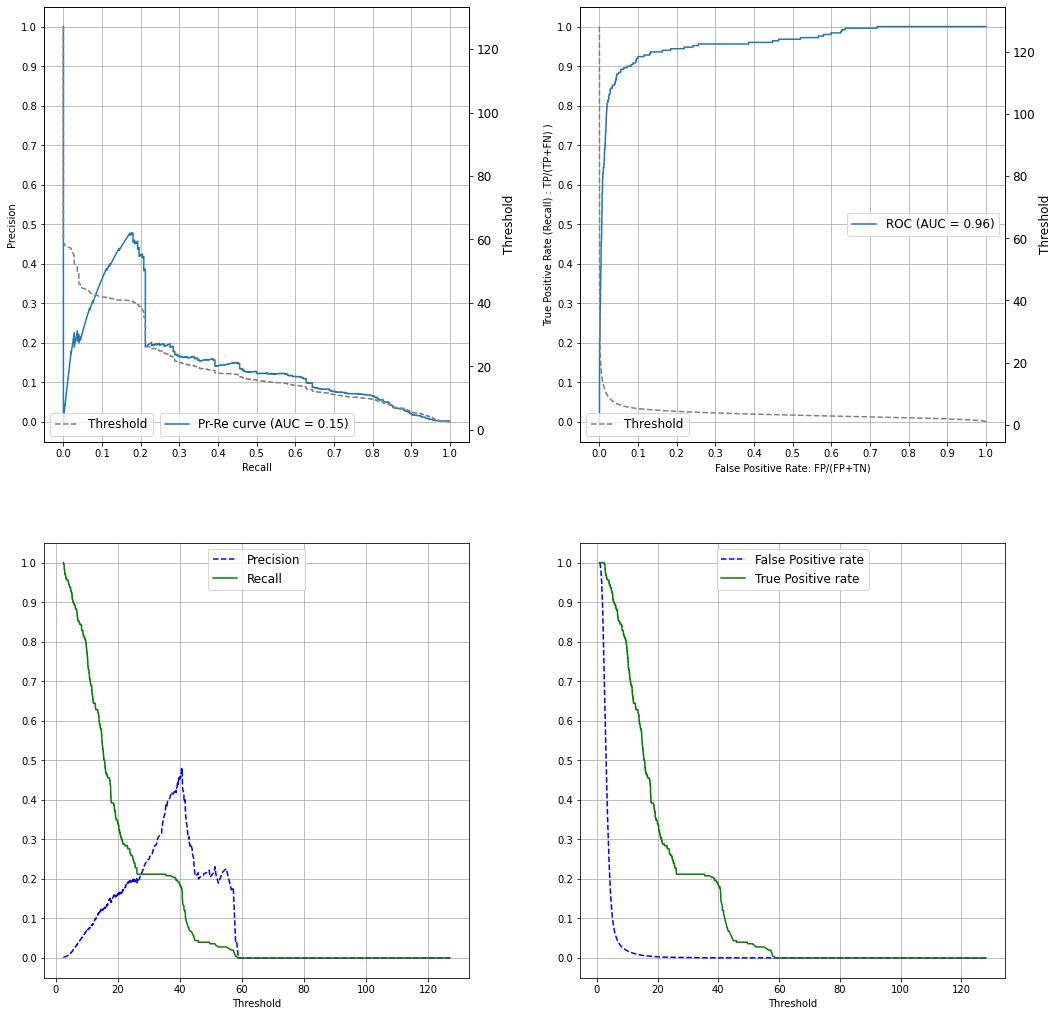

time: 1.36 s (started: 2021-05-03 23:25:16 +00:00)


In [35]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Look at the ROC curve (top right figure). It is possible to have a True Positive Rate (Recall) >= 90%, while having a false positive rate <= 10%.
In other words, we can construct an anomaly detector able to find 90% of the anomalies with less than 10% of false alarms.

Looking at the grey curve on that plot, we see that such a configuration is for threshold of about 5. Let us search for a good value of threshold.

Precision= 0.014124984713220008
Recall= 0.924
False Positive Rate =  0.11342004741370214
True Positive Rate =  0.924


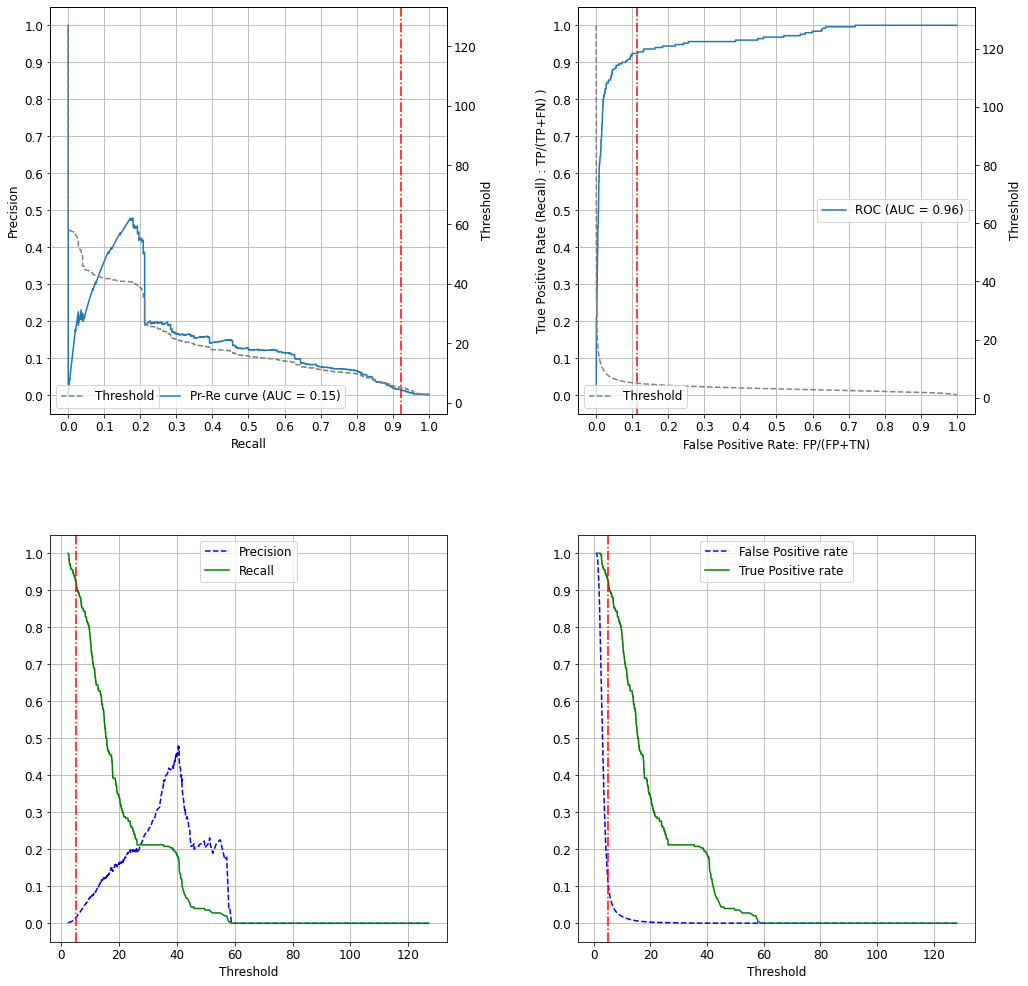

time: 2.14 s (started: 2021-05-03 23:36:59 +00:00)


In [39]:
threshold_selected = 5
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

## Evaluate the model on the test set

In [40]:
X_test_scaled = scaler.transform(X_test)
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)


Precision: 0.01330540840211901
Recall:  0.8925619834710744
False Positive Rate: 0.11267427301247872
time: 3.33 s (started: 2021-05-03 23:40:00 +00:00)


* Precision 13%: when the model says "anomaly!", it is right 13% of the time.
* Recall 89%: the model captures 89% of the anomalies
* False positive rate 11%: 11% of normal samples are erroneously classified as anomalies

Normalized confusion matrix
[[0.88732573 0.11267427]
 [0.10743802 0.89256198]]


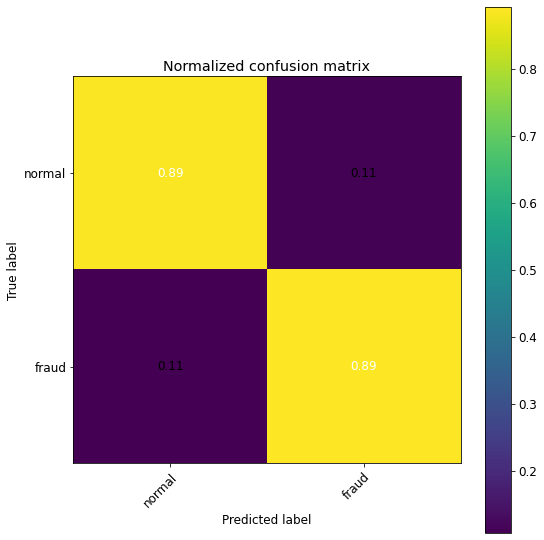

time: 613 ms (started: 2021-05-03 23:41:53 +00:00)


In [42]:
class_names = np.array(["normal", "fraud"])
plot_conf_mat(y_test, y_pred, class_names)

The model is not bad, but we can further improve it.

# Second autoencoder: only using normal samples

We now train the auto-ecoder only on the normal samples

In [43]:
# Select the normal samples
normal_samples_idx = [i for i in range(len(y_train)) if y_train[i]==0 ]
print("Found ", len(normal_samples_idx), "normal samples over ", len(y_train))

X_tr_normal = X_tr_scaled[normal_samples_idx, :]
X_tr_normal.shape

Found  142153 normal samples over  142403


(142153, 29)

time: 38.7 ms (started: 2021-05-03 23:47:45 +00:00)


In [44]:
model = make_autoencoder(layer_sizes=first_architecture, learning_rate=0.005)

time: 39.1 ms (started: 2021-05-03 23:47:45 +00:00)


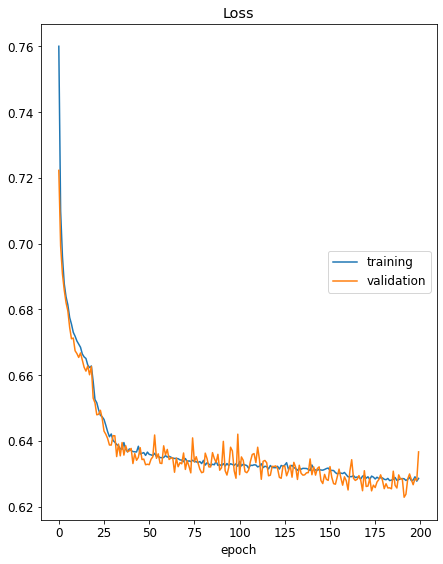

Loss
	training         	 (min:    0.628, max:    0.760, cur:    0.629)
	validation       	 (min:    0.623, max:    0.722, cur:    0.637)
time: 26min 9s (started: 2021-05-03 23:47:54 +00:00)


In [46]:
nn_file = my_path + 'nn-normal-samples-lr_0.005.h5'
history = train_model(model, nn_file, X_tr_normal, X_tr_normal, seed=5, 
                      max_epochs=200)

In [47]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

time: 2.81 s (started: 2021-05-04 00:14:14 +00:00)


Precision= 0.013690404707577758
Recall= 0.912
False Positive Rate =  0.11555155360773252
True Positive Rate =  0.912


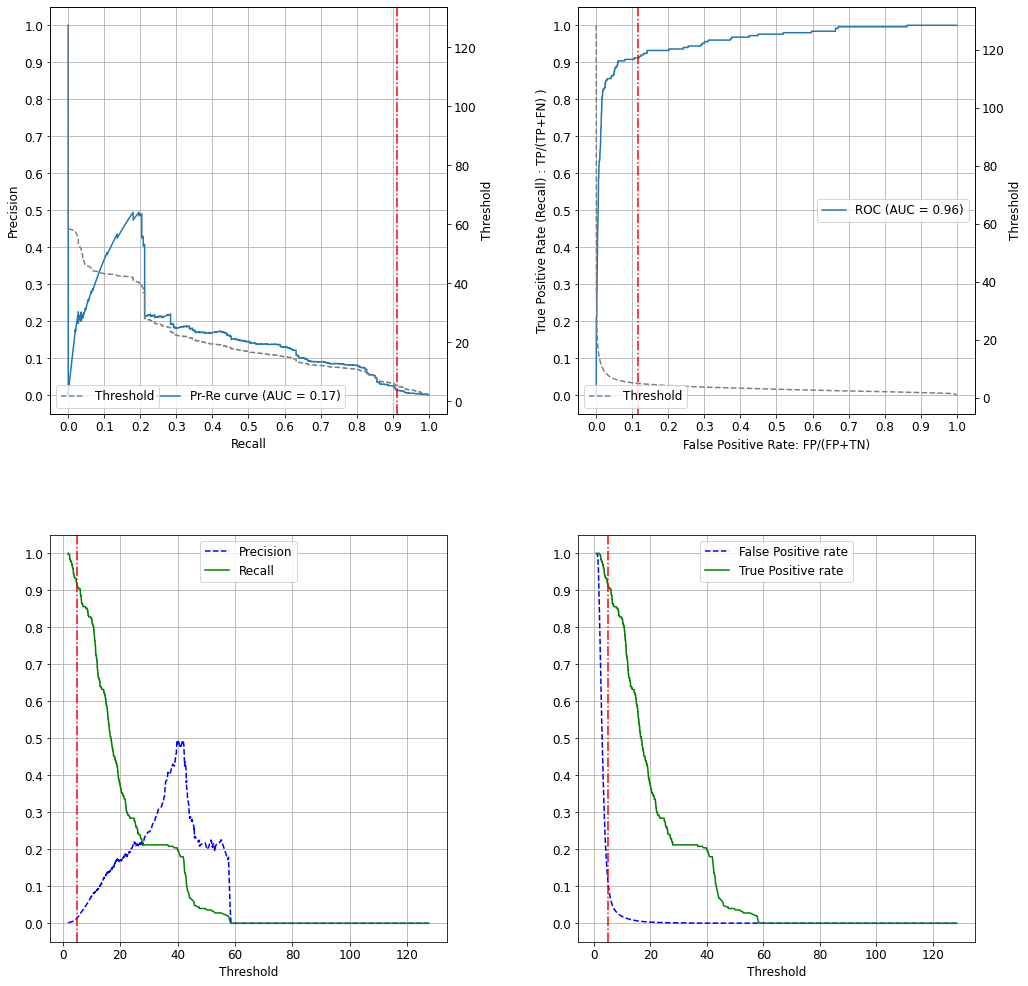

time: 2.38 s (started: 2021-05-04 00:28:21 +00:00)


In [49]:
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

In [50]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

Precision: 0.012872424004351242
Recall:  0.8801652892561983
False Positive Rate: 0.11489708923622347
time: 3.35 s (started: 2021-05-04 00:29:21 +00:00)


Normalized confusion matrix
[[0.88510291 0.11489709]
 [0.11983471 0.88016529]]


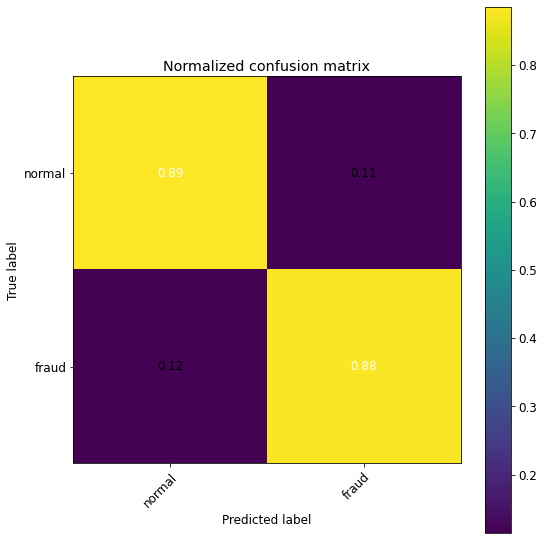

time: 611 ms (started: 2021-05-04 00:30:53 +00:00)


In [51]:
plot_conf_mat(y_test, y_pred, class_names)

The performance are a bit better than before

# Deep autoencoder



In [ ]:
deep_architecture = [25, 20, 15, 10, 15, 20, 25, n_features]

model = make_autoencoder(layer_sizes=deep_architecture, learning_rate=0.005)

nn_file = my_path + 'deep-lr_0.005.h5'
history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5, 
                      max_epochs=200)

In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)


In [ ]:
threshold_selected = 5
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

In [ ]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

In [ ]:
plot_conf_mat(y_test, y_pred, class_names)

# Solve the underfitting: Enlarge encoding layer

We may be compressing information too much. We need to allow the model to better adapt to the input data, by increasing the encoding layer

In [ ]:
def build_model():

  model = Sequential([
      Dense(20, input_dim = n_features, activation=act_fun), # Encoder
      Dense(10, activation=act_fun), ### Latent representation
      Dense(20, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 4.03 ms


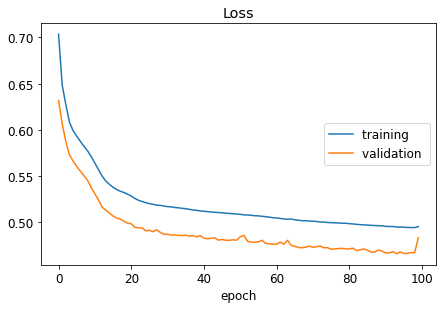

Loss
	training         	 (min:    0.494, max:    0.844, cur:    0.495)
	validation       	 (min:    0.465, max:    0.786, cur:    0.483)
3561/3561 [==============================] - 8s 2ms/step - loss: 0.4948 - val_loss: 0.4827
time: 13min 40s


In [ ]:
nn_file = my_path + 'nn2.h5'

model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)


We reduced the loss, but it is still high

In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

time: 2.89 s


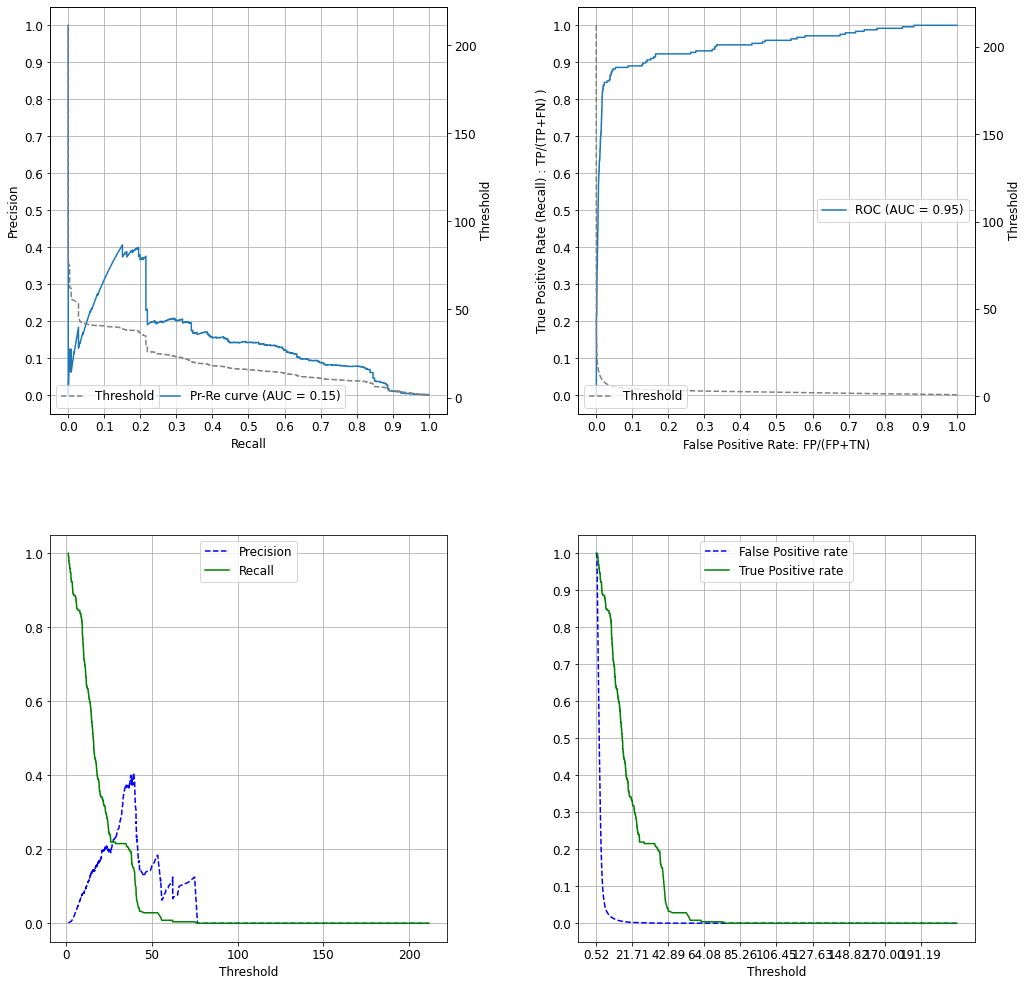

time: 1.27 s


In [ ]:
evaluate_anomaly_detector(y_train, anomaly_scores)

# Solve underfitting: Deeper autoencoder

To solve underfitting, we need to make the model more flexible, i.e., more complex. We have tried to increase the encoding layer. Now, we try also to increase the depth, i.e., the numbr of layers.

In [ ]:
def build_model():

  model = Sequential([
      Dense(20, input_dim = n_features, activation=act_fun), # Encoder
      Dense(15, activation=act_fun), # Encoder
      Dense(10, activation=act_fun), ### Latent representation
      Dense(15, activation=act_fun), # Decoder
      Dense(20, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 6.78 ms


Google interrupted my run and raised an error. Fortunately, the callbacks saved the status of the NN at every epoch.

The easiest way to recover the NN trained before the error is to add few training epochs.

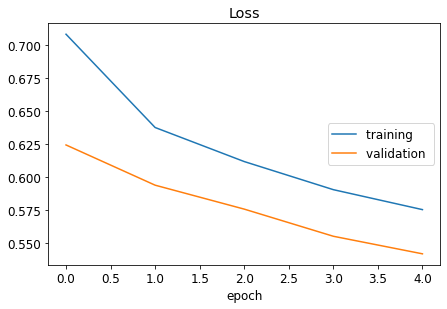

Loss
	training         	 (min:    0.494, max:    0.844, cur:    0.575)
	validation       	 (min:    0.465, max:    0.786, cur:    0.541)
3561/3561 [==============================] - 9s 2ms/step - loss: 0.5751 - val_loss: 0.5415
time: 44.6 s


In [ ]:
nn_file = my_path + 'nn3.h5'

model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=5)


Let's plot the entire training history

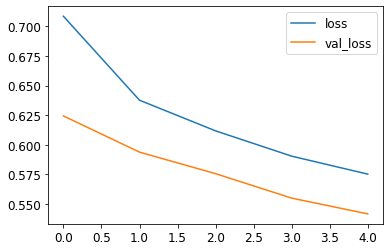

time: 172 ms


In [ ]:
def plot_train_hist(csv_hist_file):
  hist_df = pd.read_csv(csv_hist_file)
  hist_df[['loss', 'val_loss']].plot()

plot_train_hist(nn_file+'.csv')

We reduced the loss, but not that much.

# Even larger encoding layer

In [ ]:
def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(24, activation=act_fun), # Encoder
      Dense(20, activation=act_fun), ### Latent representation
      Dense(24, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 5.56 ms


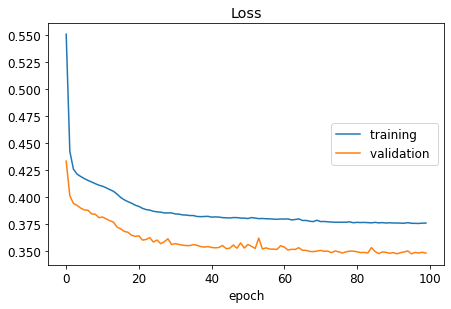

Loss
	training         	 (min:    0.376, max:    0.844, cur:    0.376)
	validation       	 (min:    0.347, max:    0.786, cur:    0.348)
3561/3561 [==============================] - 9s 2ms/step - loss: 0.3759 - val_loss: 0.3481
time: 14min 46s


In [ ]:
nn_file = my_path + 'nn4.h5'

model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

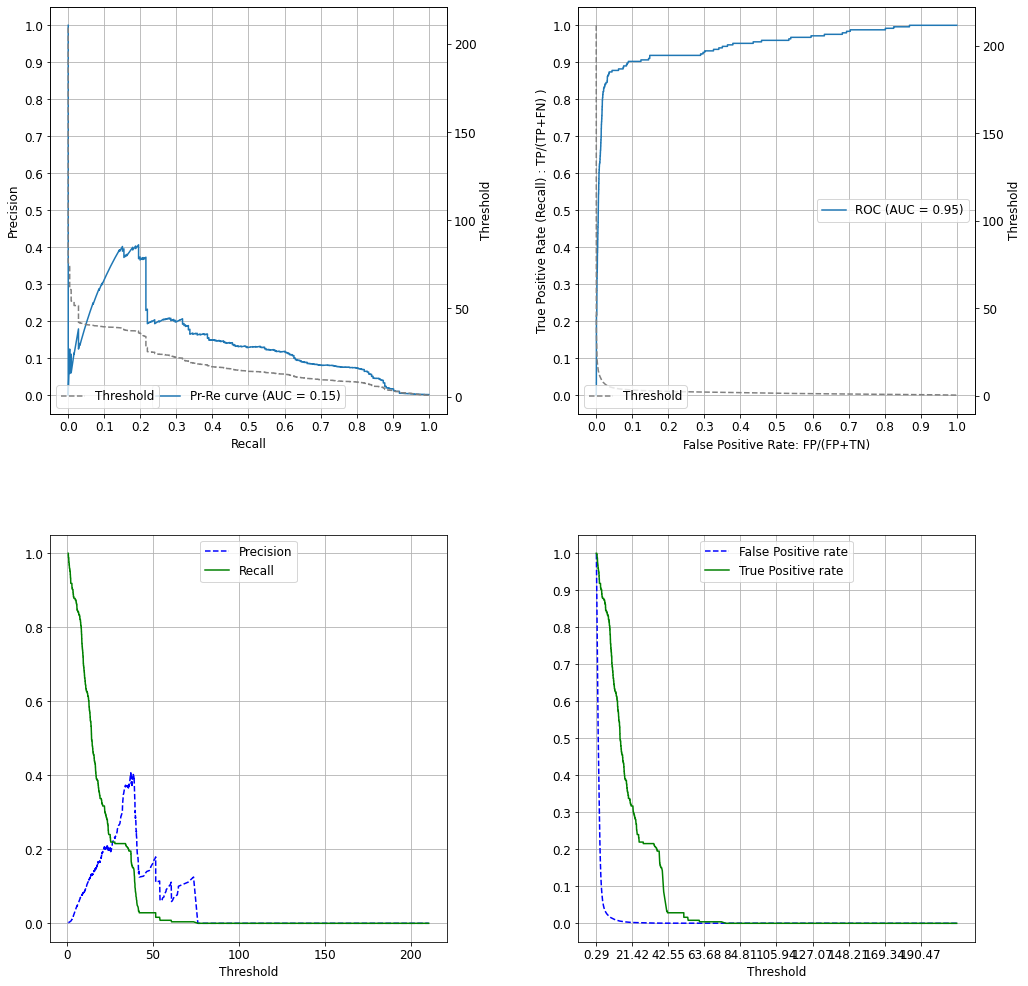

time: 4.2 s


In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

# Shallow autoencoder with large encoding layer

In [ ]:
act_fun = 'tanh'

def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoding layer
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 2.48 ms


In [ ]:
nn_file = my_path + 'nn8.h5'

time: 1.51 ms


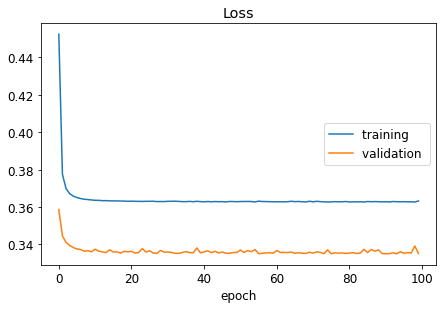

Loss
	training         	 (min:    0.363, max:    0.844, cur:    0.363)
	validation       	 (min:    0.335, max:    0.786, cur:    0.335)
3561/3561 [==============================] - 7s 2ms/step - loss: 0.3632 - val_loss: 0.3352
time: 12min 8s


In [ ]:


model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

Not a big change

### Changing activation function

In [ ]:
act_fun = 'linear'

def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoding layer
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 3.69 ms


In [ ]:
nn_file = my_path + 'nn9.h5'

time: 3.43 ms


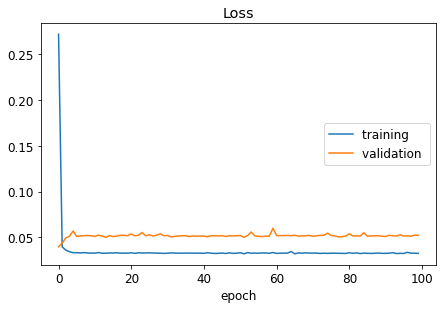

Loss
	training         	 (min:    0.032, max:    0.844, cur:    0.032)
	validation       	 (min:    0.040, max:    0.786, cur:    0.052)
3561/3561 [==============================] - 7s 2ms/step - loss: 0.0324 - val_loss: 0.0521
time: 12min


In [ ]:
model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

The autoencoder now perfectly fits (neither overfitting nor underfitting ). Is is a good thing for anomaly detection?

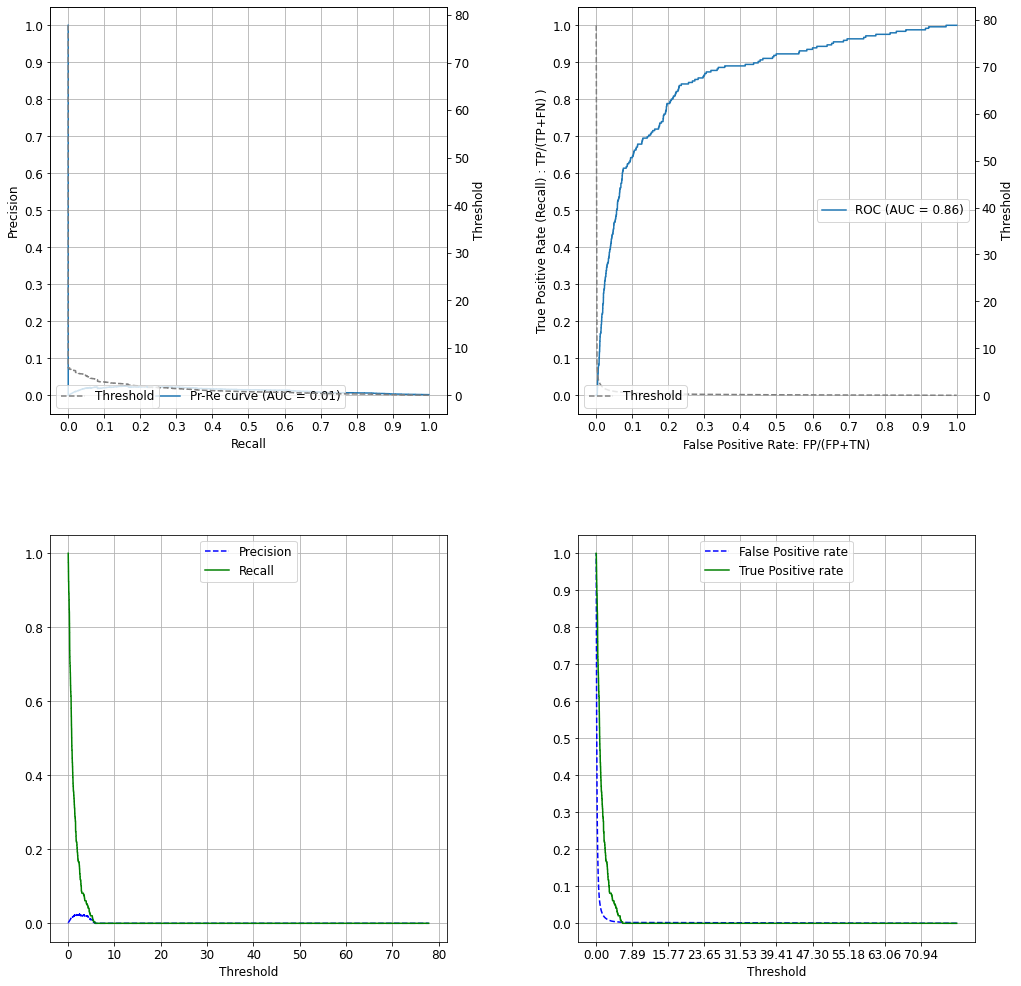

time: 3.51 s


In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

The model is "too good": it is able to learn to reproduce the anomalies.

# Other loss functions
### Mean Absolute Percentage Error

In [ ]:
act_fun = 'tanh'

def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(25, activation=act_fun), # Encoder
      Dense(23, activation=act_fun), ### Latent representation
      Dense(25, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

  return model

time: 6.33 ms


In [ ]:
nn_file = my_path + 'nn10.h5'

time: 666 µs


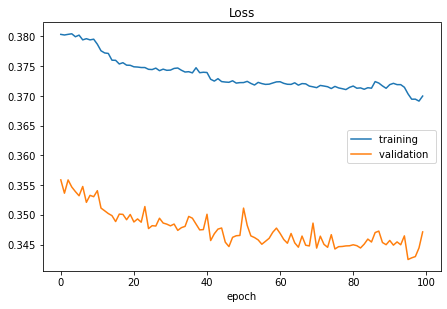

Loss
	training         	 (min:    0.369, max:    0.533, cur:    0.370)
	validation       	 (min:    0.342, max:    0.424, cur:    0.347)
3561/3561 [==============================] - 11s 3ms/step - loss: 0.3700 - val_loss: 0.3471
time: 17min 35s


In [ ]:
model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

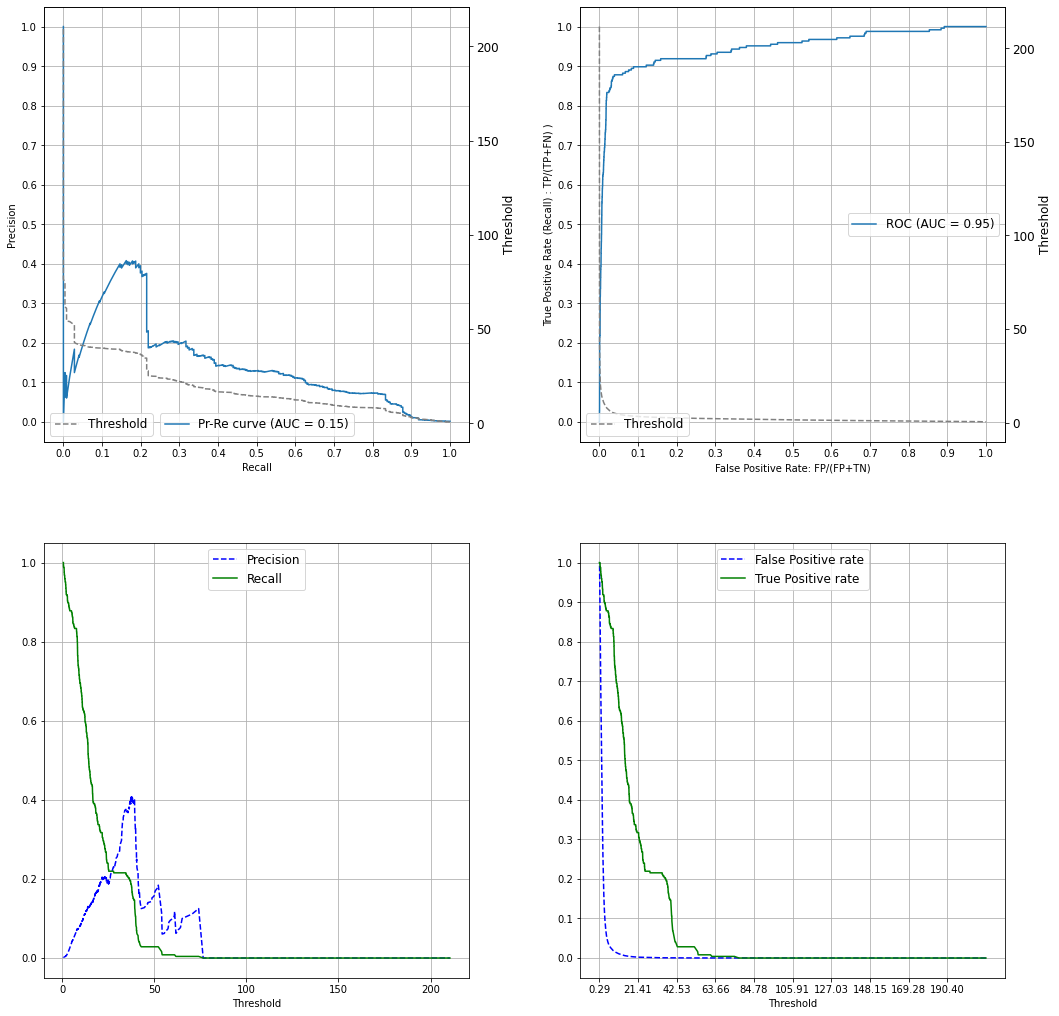

time: 4.76 s


In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

### Mean absolute error

In [ ]:
act_fun = 'tanh'

def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(25, activation=act_fun), # Encoder
      Dense(23, activation=act_fun), ### Latent representation
      Dense(25, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_absolute_error', optimizer='adam')

  return model

time: 5.72 ms


In [ ]:
nn_file = my_path + 'nn11.h5'

time: 793 µs


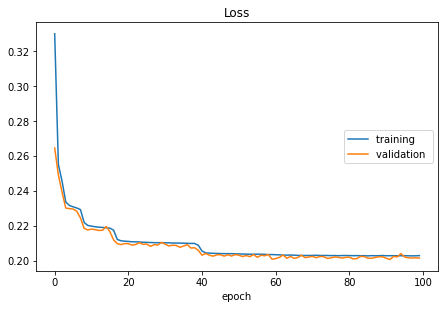

Loss
	training         	 (min:    0.203, max:    0.330, cur:    0.203)
	validation       	 (min:    0.201, max:    0.264, cur:    0.201)
3561/3561 [==============================] - 9s 2ms/step - loss: 0.2029 - val_loss: 0.2015
time: 14min 41s


In [ ]:
model = train_model(nn_file, X_tr_scaled, X_tr_scaled, epochs=100)

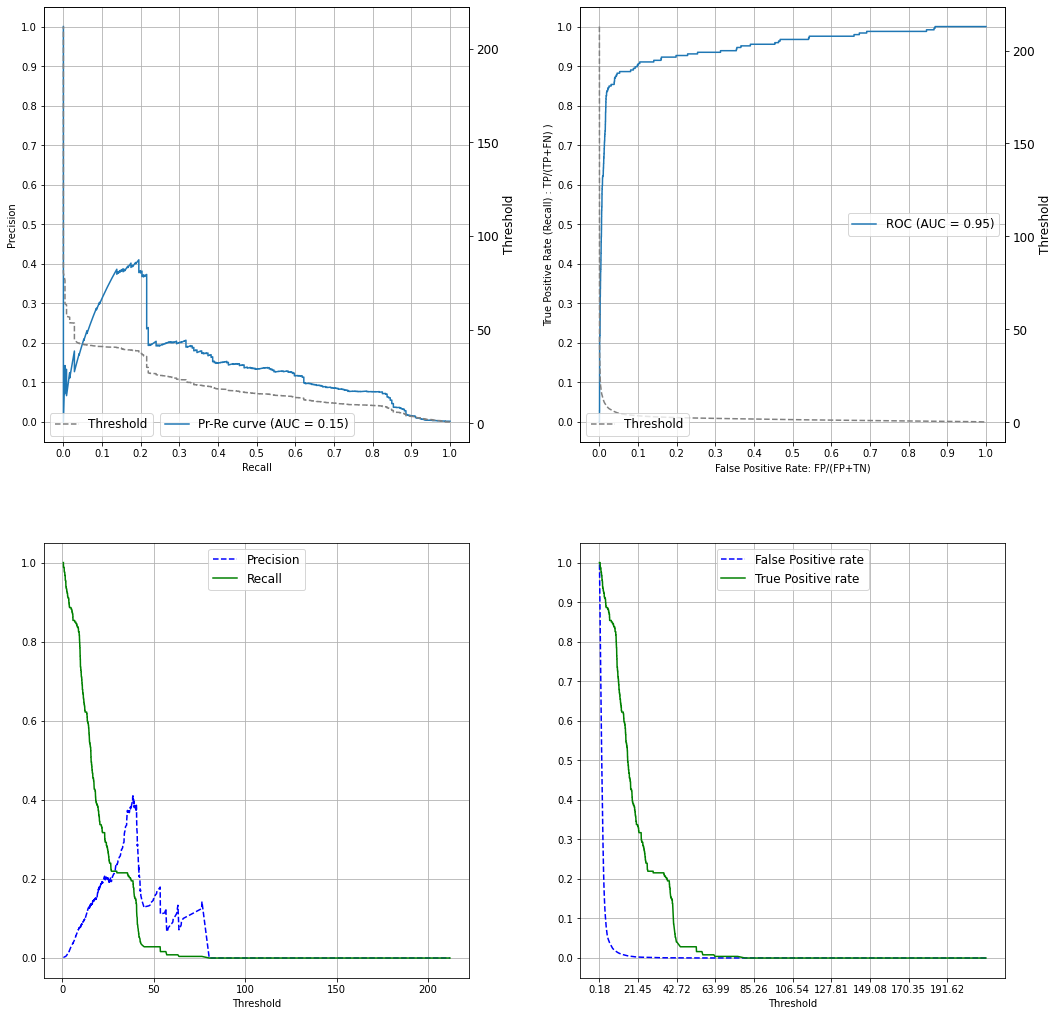

time: 4.27 s


In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

# Semi-supervised learning

We now train the auto-ecoder only on the normal samples

In [ ]:
# Select the normal samples
normal_samples_idx = [i for i in range(len(y_train)) if y_train[i]==0 ]
print("Found ", len(normal_samples_idx), "normal samples over ", len(y_train))

X_normal = X_tr_scaled[normal_samples_idx, :]
X_normal.shape

Found  142157 normal samples over  142403


(142157, 29)

time: 64 ms


### With tanh

In [ ]:
def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(25, activation=act_fun), # Encoder
      Dense(23, activation=act_fun), ### Latent representation
      Dense(25, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 4.22 ms


In [ ]:
nn_file = my_path + 'nn12.h5'

time: 683 µs


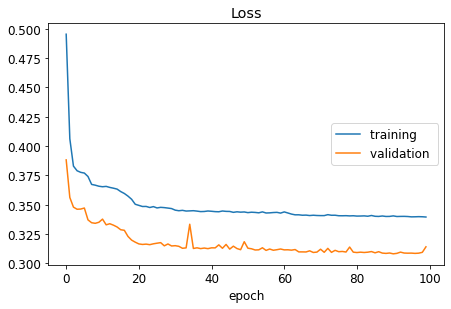

Loss
	training         	 (min:    0.203, max:    0.495, cur:    0.339)
	validation       	 (min:    0.201, max:    0.388, cur:    0.314)
3554/3554 [==============================] - 8s 2ms/step - loss: 0.3394 - val_loss: 0.3140
time: 14min 27s


In [ ]:
model = train_model(nn_file, X_normal, X_normal, epochs=100)

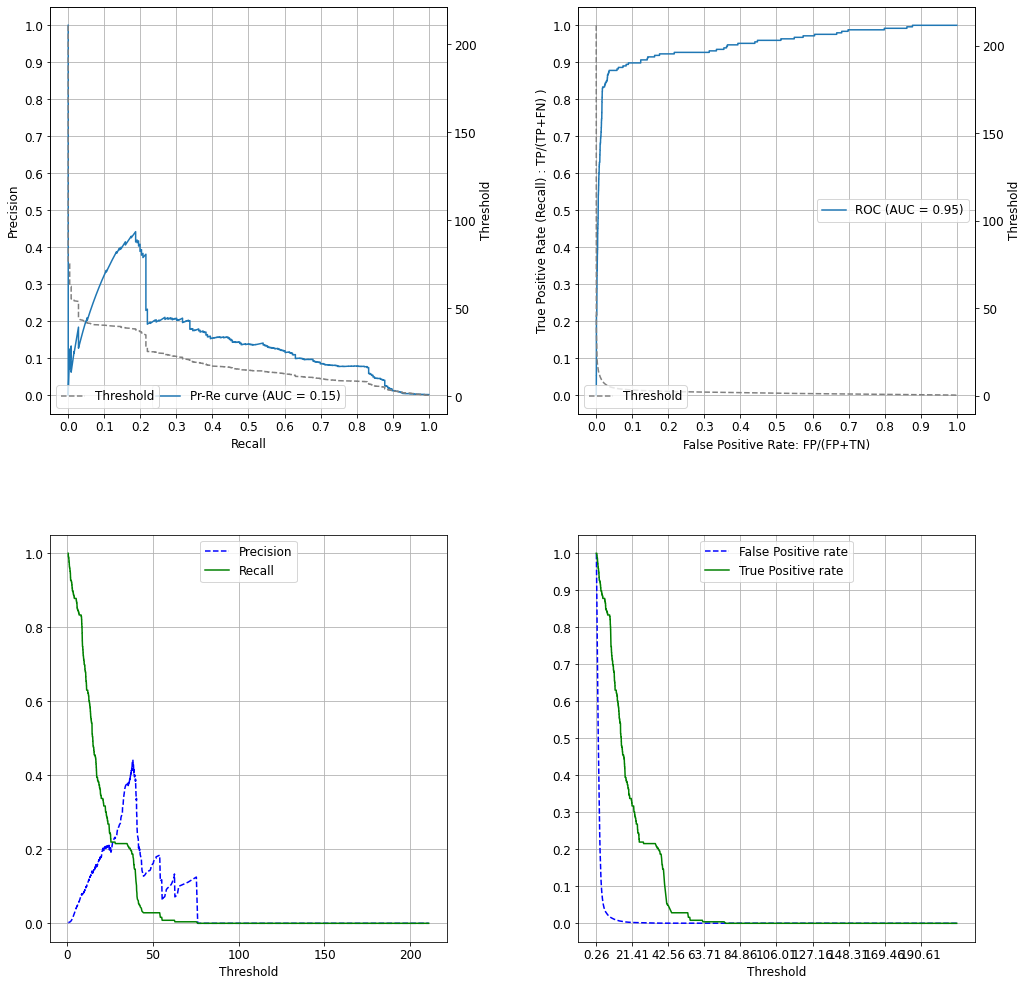

time: 4.43 s


In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

### With linear activation function

In [ ]:
act_fun = "linear"
def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(25, activation=act_fun), # Encoder
      Dense(23, activation=act_fun), ### Latent representation
      Dense(25, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 3.49 ms


In [ ]:
nn_file = my_path + 'nn13.h5'

time: 952 µs


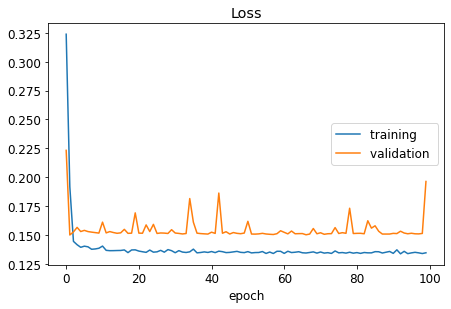

Loss
	training         	 (min:    0.134, max:    0.495, cur:    0.135)
	validation       	 (min:    0.150, max:    0.388, cur:    0.196)
3554/3554 [==============================] - 9s 2ms/step - loss: 0.1348 - val_loss: 0.1964
time: 14min 5s


In [ ]:
model = train_model(nn_file, X_normal, X_normal, epochs=100)

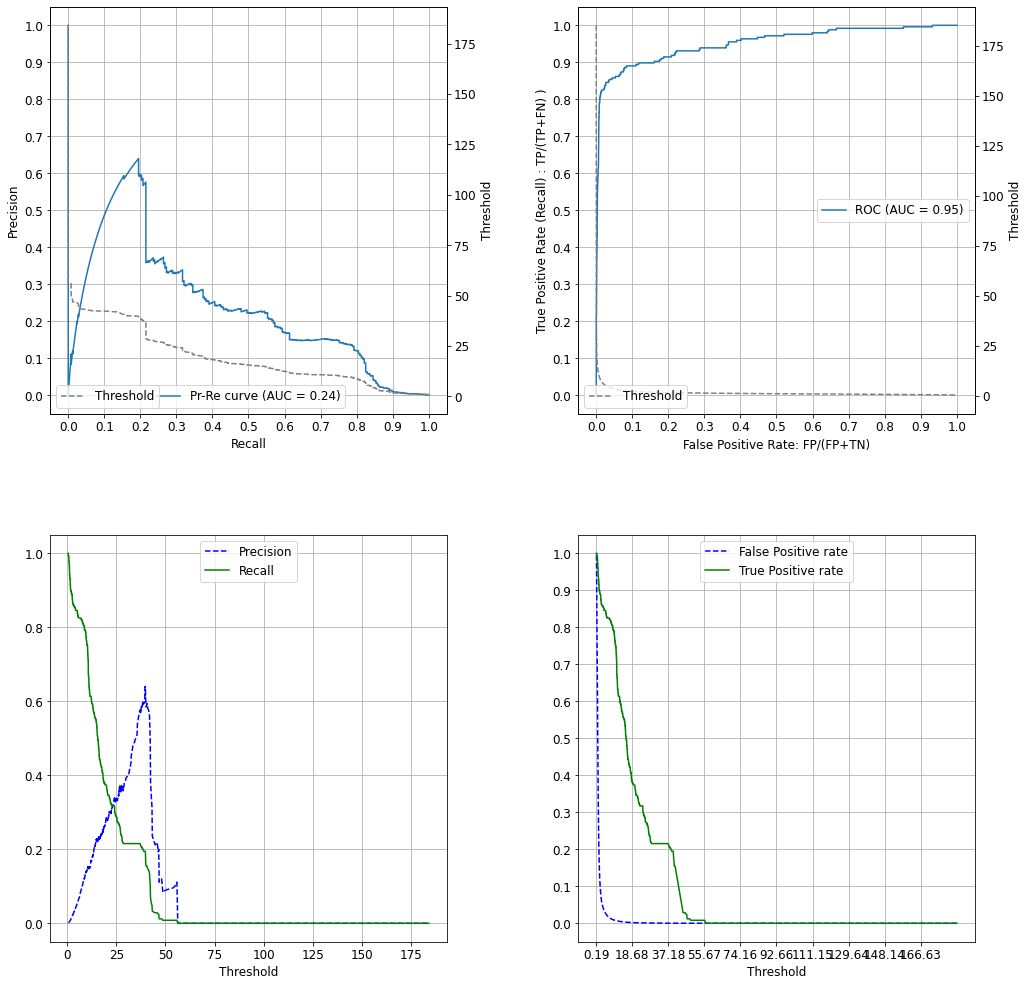

time: 4.09 s


In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

# Selected architecture

Many architectures are equivalent. We select here one of them. We do not train it from scratch, we just reload the previously trained version

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 27)                810       
_________________________________________________________________
dense_15 (Dense)             (None, 24)                672       
_________________________________________________________________
dense_16 (Dense)             (None, 20)                500       
_________________________________________________________________
dense_17 (Dense)             (None, 24)                504       
_________________________________________________________________
dense_18 (Dense)             (None, 27)                675       
_________________________________________________________________
dense_19 (Dense)             (None, 29)                812       
Total params: 3,973
Trainable params: 3,973
Non-trainable params: 0
____________________________________________________

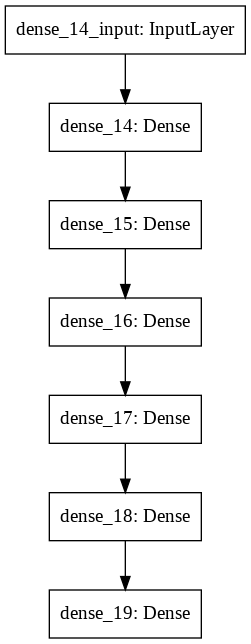

time: 9.75 s


In [ ]:
nn_file = my_path + 'nn4.h5'
model = load_model(nn_file)

model.summary()
plot_model(model)

Decide a threshold

Precision= 0.07181522915914833
Recall= 0.8089430894308943
False Positive Rate =  0.018092672186385474
True Positive Rate =  0.8089430894308943


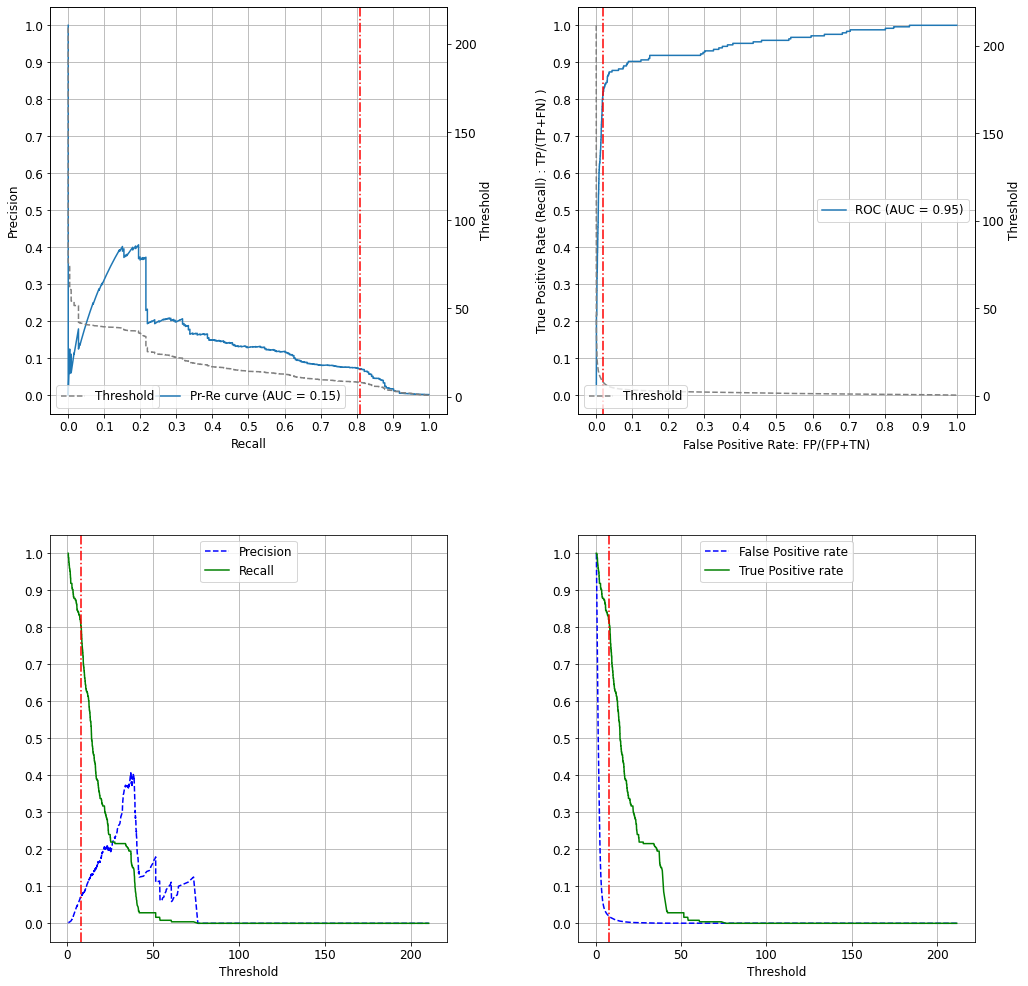

time: 6.05 s


In [ ]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)


threshold_selected=8
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

With this threshold
* We find 81% of frauds
* Only 7% of alarms raised are true frauds
* For 2% of normal activities, we raise a false alarm

# Test

In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)


Precision: 0.07003610108303249
Recall:  0.7886178861788617
False Positive Rate: 0.01812068262074593
time: 4.29 s


Normalized confusion matrix
[[0.98187932 0.01812068]
 [0.21138211 0.78861789]]


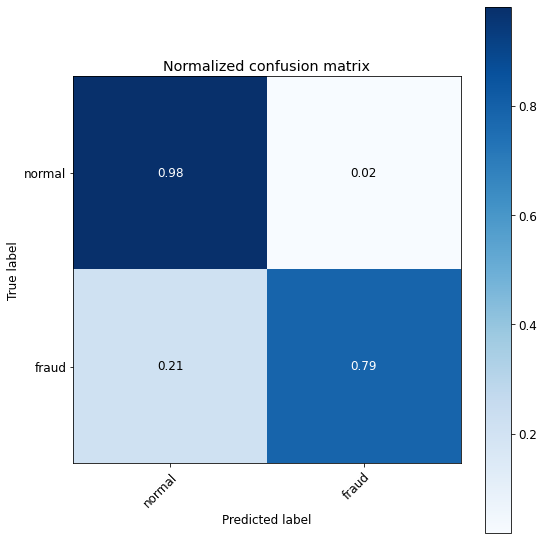

time: 655 ms


In [ ]:
class_names = np.array(["normal", "fraud"])
plot_conf_mat(y_test, y_pred, class_names)

# Other examples of Autoencoders for anomaly detection

* Application of autoencoders to the same dataset: Ch.8 of A. Patel, Hands-on unsupervised learning using Python, O'Reilly, 2019
* [Handwritten digits](https://visualstudiomagazine.com/articles/2019/03/01/neural-anomaly-detection-using-keras.aspx)